In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from IPython.display import Image, display

Using TensorFlow backend.


In [3]:
def create_model(n_samples, out_dense_1, out_dense_2, kernel_size, n_kernels):    
    # Number of neurons for the dense layers.
    n_in_layer_1 = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_in_layer_1 * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_in_layer_1:",
          n_in_layer_1, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1_a = []
    layer_2_a = []
    layer_1_b = []
    layer_2_b = []
    
    for i in range(n_in_layer_1):
        layer_1_a.append(Dense(out_dense_1, activation='relu', name='layer_1_a_{:02d}'.format(i))(model))
        layer_1_b.append(Dense(out_dense_1, activation='relu', name='layer_1_b_{:02d}'.format(i))(model))
        layer_2_a.append(Dense(out_dense_2, activation='relu', name='layer_2_a_{:02d}'.format(i))(layer_1_a[-1]))
        layer_2_b.append(Dense(out_dense_2, activation='relu', name='layer_2_b_{:02d}'.format(i))(layer_1_b[-1]))
    
    # Concatenate and reshape both sides.
    concat_a = Concatenate()(layer_2_a)
    print("Shape after concat_a:", concat_a.shape)
    
    reshape_a = Reshape(target_shape=(out_dense_total, 1, 1))(concat_a)
    print("Shape after reshape_a:", reshape_a.shape)
        
    concat_b = Concatenate()(layer_2_b)
    print("Shape after concat_b:", concat_b.shape)
    
    reshape_b = Reshape(target_shape=(out_dense_total, 1, 1))(concat_b)
    print("Shape after reshape_b:", reshape_b.shape)
    
    # Concatenate sides a and b.
    concat_both = Concatenate(-2)([reshape_a, reshape_b])
    print("Shape after concat_both:", concat_both.shape)
    
    # 2D Convolution and reshaping after concatenating
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, 2), strides=1)(concat_both)
    print("Shape after conv2d:", conv.shape)
    
    reshape_conv = Reshape(target_shape=(n_samples, n_kernels))(conv)
    print("Shape after reshape_conv:", reshape_conv.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(reshape_conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [4]:
def gen_data_mesh(n_data, mu_range, sd_range, n_samples, x_range):
    # Generate spaces.
    mu, sd = np.meshgrid(np.linspace(mu_range[0], mu_range[1], n_data), np.linspace(sd_range[0], sd_range[1], n_data))
    mu, sd = mu.ravel(), sd.ravel()
    x = np.linspace(x_range[0], x_range[1], n_samples)

    # Sample from standard normal distribution.
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])

    # Transform mu to match input format.
    params = np.array((mu, sd)).T
    
    return params, x_sampled

In [5]:
def gen_data(n_data, n_samples):
    mu = ss.uniform(MIN_MU, MAX_MU).rvs(n_data)
    sd = ss.uniform(MIN_SD, MAX_SD).rvs(n_data)
    x = np.linspace(MIN_X, MAX_X, n_samples)

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_sampled

In [10]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -10, 10
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA = 25000
N_SAMPLES = 150
N_ITER = 100

# NN Settings.
OUT_D_1 = 10
OUT_D_2 = 40
K_SIZE = 40
N_K = 50

out_dense_1: 10 
out_dense_2: 40 
n_in_layer_1: 5 
out_dense_total: 200 
kernel_size: 51 
n_kernels: 50
Shape after input: (?, 2)
Shape after concat_a: (?, 200)
Shape after reshape_a: (?, 200, 1, 1)
Shape after concat_b: (?, 200)
Shape after reshape_b: (?, 200, 1, 1)
Shape after concat_both: (?, 200, 2, 1)
Shape after conv2d: (?, 150, 1, 50)
Shape after reshape_conv: (?, 150, 50)
Shape after avg: (?, 150)


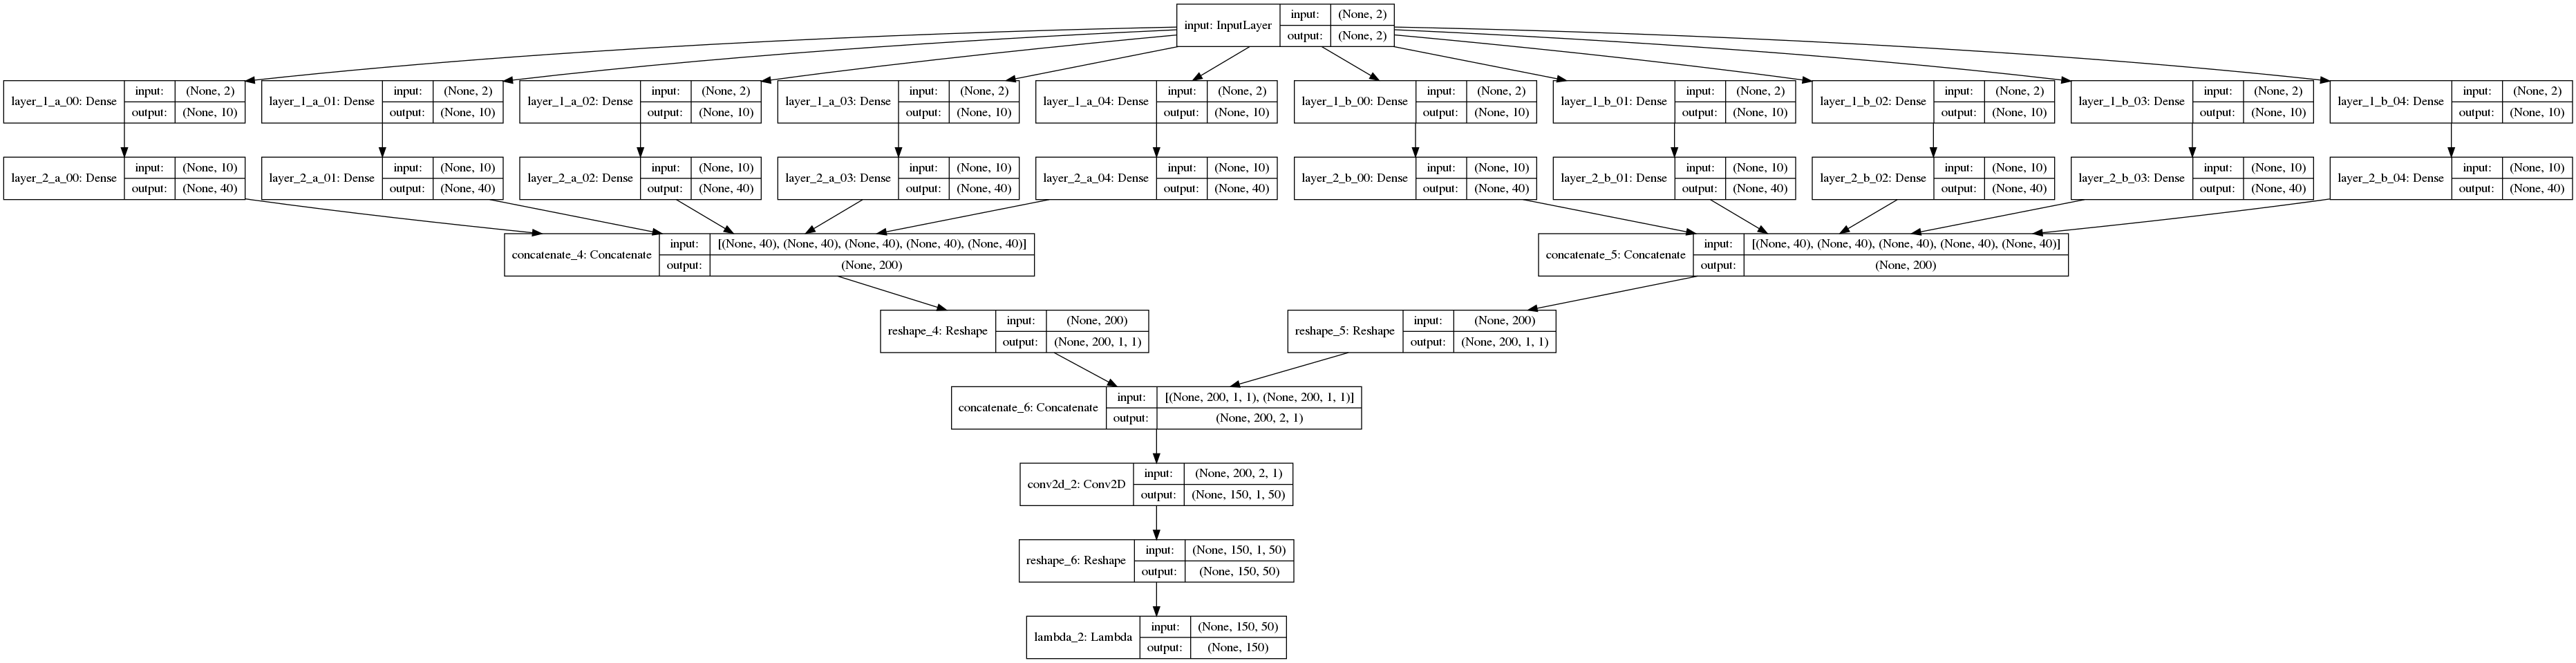

Epoch 1/5
25000/25000 [==============================] - 3s 113us/step - loss: 622.8558
Epoch 2/5
25000/25000 [==============================] - 2s 98us/step - loss: 36.1392
Epoch 3/5
25000/25000 [==============================] - 2s 98us/step - loss: 10.5998
Epoch 4/5
25000/25000 [==============================] - 2s 99us/step - loss: 5.4011
Epoch 5/5
25000/25000 [==============================] - 2s 98us/step - loss: 3.4500
Epoch 1/5
25000/25000 [==============================] - 2s 98us/step - loss: 2.3235
Epoch 2/5
25000/25000 [==============================] - 2s 98us/step - loss: 1.8343
Epoch 3/5
25000/25000 [==============================] - 3s 103us/step - loss: 1.3556
Epoch 4/5
25000/25000 [==============================] - 2s 99us/step - loss: 1.2933
Epoch 5/5
25000/25000 [==============================] - 3s 100us/step - loss: 0.9055
Epoch 1/5
25000/25000 [==============================] - 3s 107us/step - loss: 1.2167
Epoch 2/5
25000/25000 [==============================] - 

25000/25000 [==============================] - 2s 98us/step - loss: 0.6090
Epoch 3/5
25000/25000 [==============================] - 3s 101us/step - loss: 0.2698
Epoch 4/5
25000/25000 [==============================] - 2s 99us/step - loss: 0.3127
Epoch 5/5
25000/25000 [==============================] - 2s 98us/step - loss: 0.2550
Epoch 1/5
25000/25000 [==============================] - 2s 96us/step - loss: 0.4510
Epoch 2/5
25000/25000 [==============================] - 2s 97us/step - loss: 0.2209
Epoch 3/5
25000/25000 [==============================] - 2s 97us/step - loss: 0.5251
Epoch 4/5
25000/25000 [==============================] - 2s 97us/step - loss: 0.2314
Epoch 5/5
25000/25000 [==============================] - 2s 97us/step - loss: 0.7039
Epoch 1/5
25000/25000 [==============================] - 2s 96us/step - loss: 0.1815
Epoch 2/5
25000/25000 [==============================] - 2s 98us/step - loss: 0.3002
Epoch 3/5
25000/25000 [==============================] - 2s 98us/step - lo

25000/25000 [==============================] - 3s 103us/step - loss: 0.3072
Epoch 3/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.2160
Epoch 4/5
25000/25000 [==============================] - 3s 106us/step - loss: 0.1991
Epoch 5/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.2908
Epoch 1/5
25000/25000 [==============================] - 3s 117us/step - loss: 0.8083
Epoch 2/5
25000/25000 [==============================] - 3s 116us/step - loss: 0.1671
Epoch 3/5
25000/25000 [==============================] - 3s 113us/step - loss: 0.2217
Epoch 4/5
25000/25000 [==============================] - 3s 112us/step - loss: 0.2106
Epoch 5/5
25000/25000 [==============================] - 3s 113us/step - loss: 0.2082
Epoch 1/5
25000/25000 [==============================] - 3s 108us/step - loss: 0.2031
Epoch 2/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.2857
Epoch 3/5
25000/25000 [==============================] - 3s 108u

25000/25000 [==============================] - 3s 122us/step - loss: 0.3093
Epoch 3/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.6016
Epoch 4/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.0789
Epoch 5/5
25000/25000 [==============================] - 3s 121us/step - loss: 0.1114
Epoch 1/5
25000/25000 [==============================] - 3s 120us/step - loss: 0.1936
Epoch 2/5
25000/25000 [==============================] - 3s 123us/step - loss: 0.1796
Epoch 3/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.1289
Epoch 4/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.3040
Epoch 5/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.2060
Epoch 1/5
25000/25000 [==============================] - 3s 122us/step - loss: 0.1998
Epoch 2/5
25000/25000 [==============================] - 3s 123us/step - loss: 0.1360
Epoch 3/5
25000/25000 [==============================] - 3s 121u

25000/25000 [==============================] - 3s 110us/step - loss: 1.0101
Epoch 3/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1398
Epoch 4/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1054
Epoch 5/5
25000/25000 [==============================] - 3s 108us/step - loss: 0.0910
Epoch 1/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.2537
Epoch 2/5
25000/25000 [==============================] - 3s 108us/step - loss: 0.1276
Epoch 3/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.1775
Epoch 4/5
25000/25000 [==============================] - 3s 108us/step - loss: 0.1010
Epoch 5/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.3063
Epoch 1/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.1035
Epoch 2/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.2102
Epoch 3/5
25000/25000 [==============================] - 3s 109u

25000/25000 [==============================] - 3s 109us/step - loss: 0.0909
Epoch 3/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.1142
Epoch 4/5
25000/25000 [==============================] - 3s 111us/step - loss: 0.3460
Epoch 5/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1024
Epoch 1/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1650
Epoch 2/5
25000/25000 [==============================] - 3s 112us/step - loss: 0.3300
Epoch 3/5
25000/25000 [==============================] - 3s 109us/step - loss: 0.0643
Epoch 4/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1901
Epoch 5/5
25000/25000 [==============================] - 3s 110us/step - loss: 0.1388
Epoch 1/5
25000/25000 [==============================] - 3s 107us/step - loss: 0.1234
Epoch 2/5
25000/25000 [==============================] - 3s 111us/step - loss: 0.0832
Epoch 3/5
25000/25000 [==============================] - 3s 109u

In [11]:
model = create_model(N_SAMPLES, OUT_D_1, OUT_D_2, K_SIZE, N_K)
model.compile(optimizer='adam', loss='mean_squared_error')

for i in range(0, N_ITER):
    params, x_sampled = gen_data(N_DATA, N_SAMPLES)
    model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=5)

In [12]:
# We currently only predict on the last set of parameters.
predictions = model.predict(params)

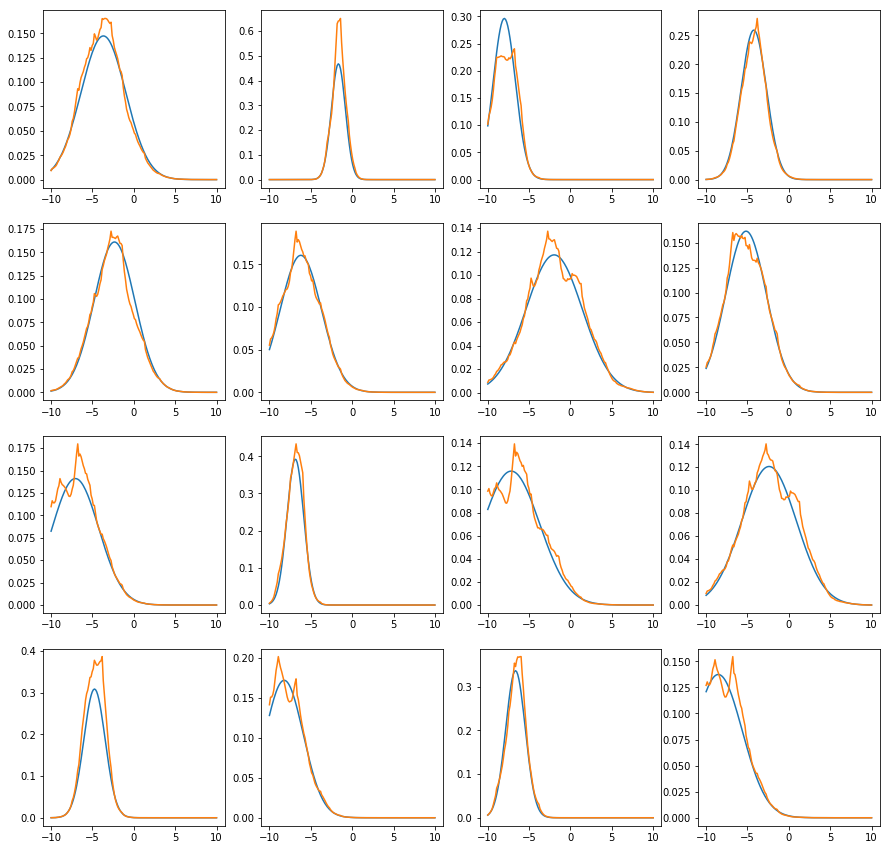

In [14]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(predictions[ix, :]))